In [11]:
#Importing required packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.pipeline import Pipeline
from sklearn.tree import export_graphviz
import pydot

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import imblearn.pipeline

from xgboost import XGBClassifier
import xgboost as xgb
from xgboost import plot_tree

from hyperopt import hp
from hyperopt import fmin, tpe

%matplotlib inline
plt.style.use('ggplot')

In [12]:
shap.initjs()

In [14]:
#Reading from local storage device
df = pd.read_csv('Fraud.csv')

In [16]:
#Finding dimensions of the imported data
df.shape

(6362620, 11)

In [71]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [19]:
#Checks for NULL & Descriptive Statistics
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [20]:
#Describing the data
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [28]:
#Pairplots of Features and target variable

original_features = [col for col in df.columns if 'isFraud' not in col]
len(original_features)

10

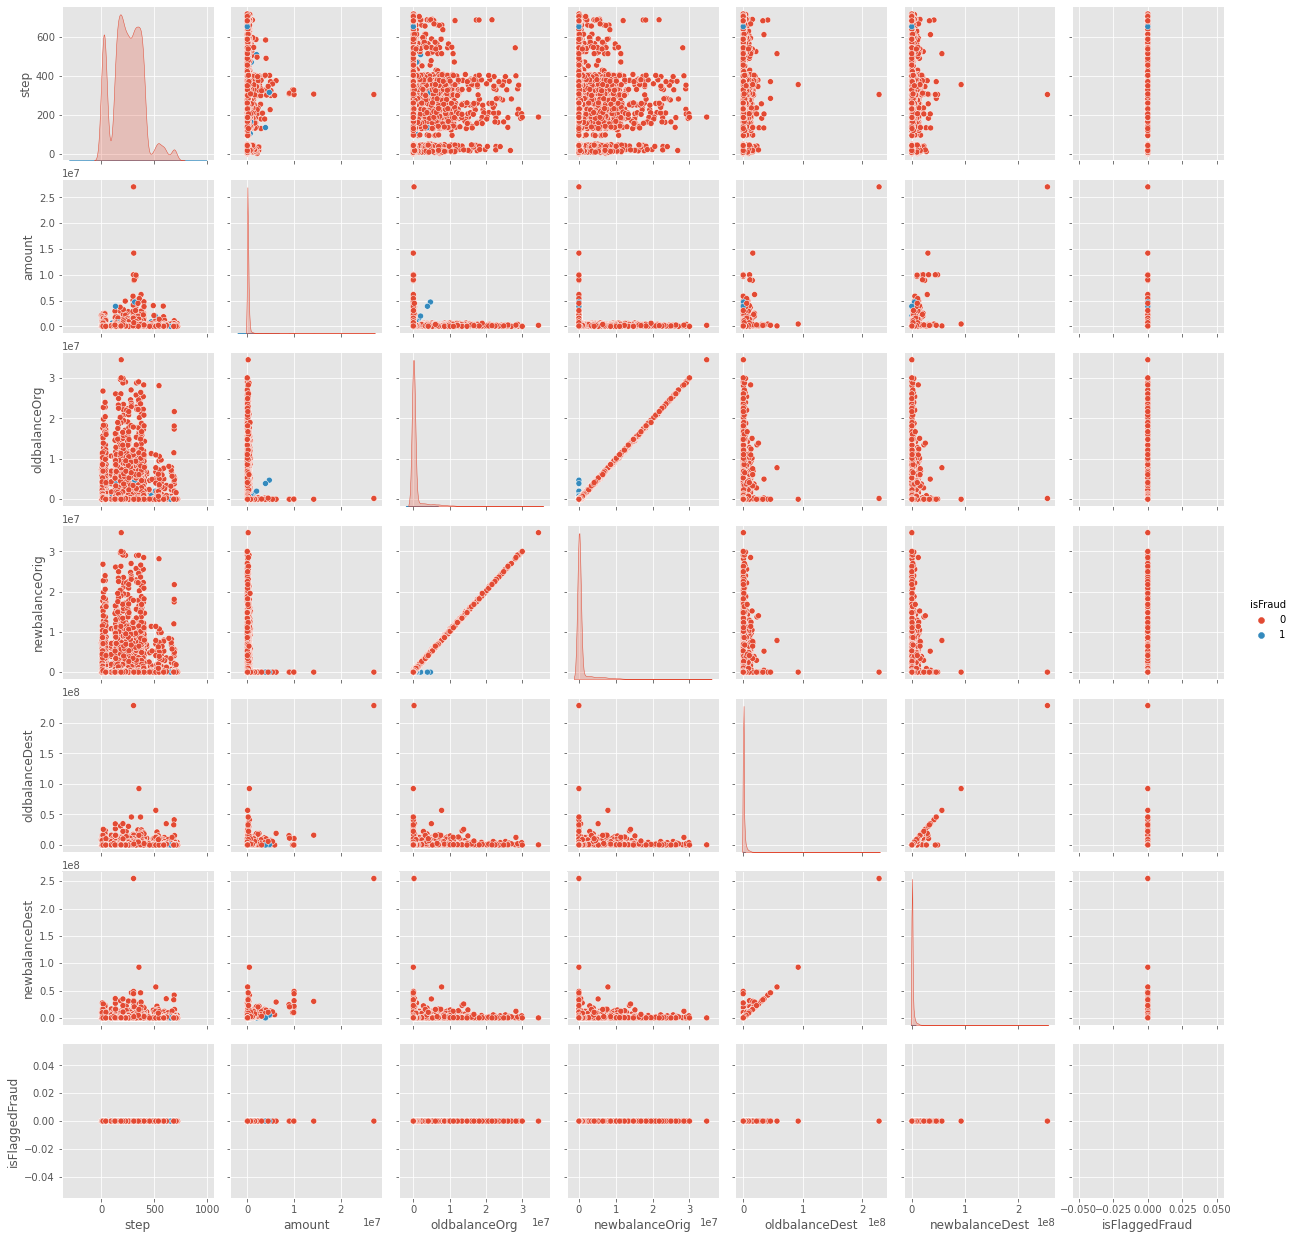

In [29]:
sns.pairplot(df[original_features[:10]+['isFraud']].sample(10000, random_state=1), hue='isFraud')

In [30]:
#Target_Variable
target = 'isFraud'

In [31]:
df[target].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

<AxesSubplot:>

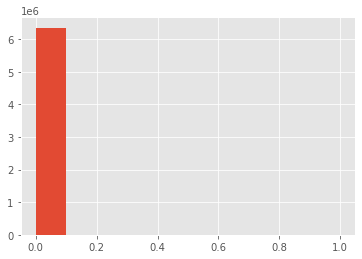

In [32]:
df[target].hist()

In [33]:
#Correlation Matrix
df_corr = df.corr()

In [34]:
df_corr.style.background_gradient().set_precision(2)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00


In [35]:
df.corr()['isFraud'].sort_values()

newbalanceOrig   -0.008148
oldbalanceDest   -0.005885
newbalanceDest    0.000535
oldbalanceOrg     0.010154
step              0.031578
isFlaggedFraud    0.044109
amount            0.076688
isFraud           1.000000
Name: isFraud, dtype: float64

In [36]:
#Training, testing and spliting
feats = df[original_features]
outp = df[target]

In [40]:
#Using stratify - to ensure fraud label is in the test set
X_train, X_test, y_train, y_test = train_test_split(feats, outp, shuffle=True, stratify=outp, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4771965, 10) (1590655, 10) (4771965,) (1590655,)


In [43]:
y_train.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [46]:
y_test.value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [47]:
#Modeling
#Predicting all Zeros
preds = np.zeros(y_test.shape[0])
len(preds)

1590655

In [49]:
roc_auc_score(y_test, preds)

0.5

In [50]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1588602
           1       0.00      0.00      0.00      2053

    accuracy                           1.00   1590655
   macro avg       0.50      0.50      0.50   1590655
weighted avg       1.00      1.00      1.00   1590655



In [51]:
#Native Models
num_boost_rounds = 1000
early_stopping_rounds = 10

initial_params = {'objective': 'binary:logistic', 'eval_metric': 'auc'}

In [65]:
logit_cv = cross_val_score(estimator=LogisticRegression(), 
                            X=X_train, 
                            y=y_train, 
                            scoring='roc_auc',
                            cv=StratifiedKFold(n_splits=5, shuffle=True))
print(logit_cv)

[nan nan nan nan nan]


In [69]:
rf_cv = cross_val_score(estimator=RandomForestClassifier(),
                         X=X_train, 
                         y=y_train,
                         scoring='roc_auc',
                         cv=StratifiedKFold(n_splits=5, random_state=None))
print(rf_cv)

[nan nan nan nan nan]


In [57]:
xgb_cv = cross_val_score(estimator=XGBClassifier(num_boost_rounds=num_boost_rounds, 
                                                 early_stopping_rounds=early_stopping_rounds,
                                                 **initial_params),
                          X=X_train,
                          y=y_train,
                          scoring='roc_auc',
                          cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=1))

In [58]:
print(f'Logistic Regression CV Mean AUC score: {logit_cv.mean()}')
print(f'Random Forest CV Mean AUC score: {rf_cv.mean()}')
print(f'XGBoost CV Mean AUC score: {xgb_cv.mean()}')

Logistic Regression CV Mean AUC score: nan
Random Forest CV Mean AUC score: nan
XGBoost CV Mean AUC score: nan
